<a href="https://colab.research.google.com/github/shryu8902/KAERI_mini_BS/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C_2_1_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%9D%B4%EC%83%81%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오토인코더를 활용한 이상탐지 실습자료

본 실습 자료에서는 오토인코더를 활용한 이상탐지 과정을 살펴보도록하겠습니다.

1. MNIST 데이터를 활용한 hold-out class 이상탐지 셋팅
2. 이상탐지를 위한 오토인코더 모델 생성 및 학습
3. 테스트 셋에 대한 이상탐지 성능 판단


실습은 pytorch와 pytorch-lightning 라이브러리를 활용하여 진행합니다.

아래의 코드 블록을 실행시키면서 결과를 확인할 수 있습니다.

MNIST 데이터 셋으로부터 0을 정상으로, 나머지 1 ~ 9를 비정상으로 가정할 것입니다.
오토인코더 모델을 학습하고, AUROC 계산까지 수행해 보도록하겟습니다.


### 라이브러리 준비

먼저 아래의 코드를 통해 필요 라이브러리를 불러옵니다.

In [ ]:
!pip install pytorch-lightning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import transforms 
from torchvision.datasets import MNIST
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.3 MB/s eta 0:00:00


### MNIST 데이터셋 준비

라이브러리 내장 함수를 활용해서 MNIST 데이터셋을 다운로드하고 이상탐지 실습을 위한 데이터셋을 구성합니다.

In [ ]:
dataset_train = MNIST('', train=True, download=True, transform=transforms.ToTensor())
dataset_test = MNIST('',train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



각 데이터셋을 프린트해보면 데이터셋 구성에 대한 설명을 확인할 수 있습니다.

 train, test데이터가 각각 60000개, 10000개로 구성되어있는 것을 확인할 수 있습니다.

In [ ]:
print(dataset_train)
print(dataset_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()


다음으로 이상탐지를 위한 hold-out class detection으로 데이터를 재구성하겠습니다.

0을 정상데이터로, 그외 클래스 (1~9)는 비정상데이터로 가정할 것입니다.

테스트셋 내의 정상 데이터 (0인 데이터)의 수가 980개이므로, 비정상 테스트셋의 수를 동일하게 맞추도록 하겠습니다.

코드 수행 결과 정상 학습 입력데이터, 정상 테스트 입력 데이터, 비정상 테스트 입력 데이터를 생성합니다.

In [ ]:
NORMAL_CLASS = 0 # 정상 클래스 label을 0으로
normal_train_input = dataset_train.data[dataset_train.targets == NORMAL_CLASS]/256 #학습 데이터셋 내 0인 데이터를 정상 학습 데이터셋으로 + 데이터 정규화
normal_test_input = dataset_test.data[dataset_test.targets == NORMAL_CLASS]/256 #테스트 데이터셋 내 0인 데이터를 정상 테스트 데이터셋으로 + 데이터 정규화
abnormal_test_input = dataset_test.data[dataset_test.targets != NORMAL_CLASS][:980]/256 #테스트 데이터셋 내 0 외 데이터를 비정상 테스트 데이터셋으로 + 데이터 정규화
print(len(normal_train_input))
print(len(normal_test_input))
print(len(abnormal_test_input))

5923
980
980


학습 정상 데이터와 테스트 비정상 데이터에 대한 샘플들을 그려보도록하겠습니다.

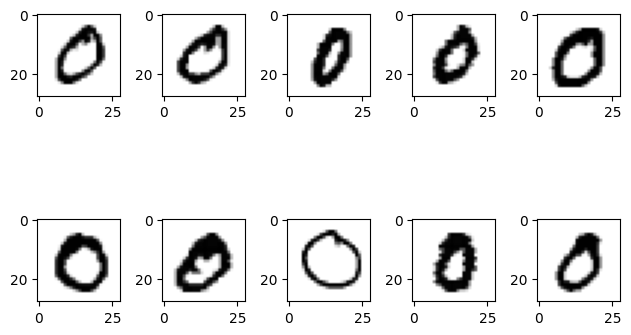

In [ ]:
for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(normal_train_input[i,...], cmap=plt.cm.gray_r)
plt.tight_layout()

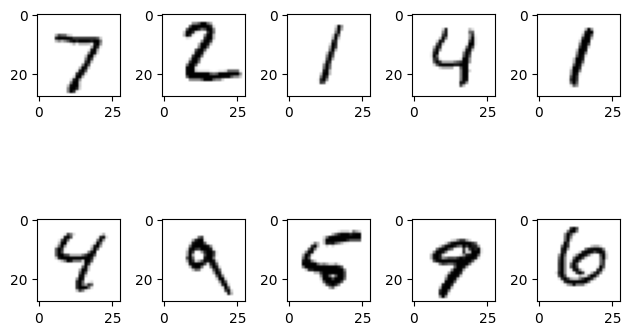

In [ ]:
for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(abnormal_test_input[i,...], cmap=plt.cm.gray_r)
plt.tight_layout()

입력 데이터의 형태를 살펴보겠습니다.
그레이 스케일 데이터이기 때문에 [H,W] 의 shape을 가지고 있습니다.

In [ ]:
abnormal_test_input[0,...].shape

torch.Size([28, 28])

## 딥러닝 모델 만들기

파이토치 라이트닝 모듈로  간단한 오토인코더 모델을 구현해보도록하겠습니다.
파이토치 라이트닝은 파이토치에 대한 high-level interface를 제공하여 쉽게 모델 개발 및 학습을 할 수 있도록 도와줍니다.


파이토치 라이트닝 모델은 딥러닝 모델을 정의하고, 라이트닝 모델 내에서 training, validation, test, predict 수행 내용들을 정의하면 라이브러리에서 제공하는 trainer를 통해 keras와 유사하게 fit,predict function 들을 통해 모델을 활용할 수 있습니다.


오토인코더는 가장 기본적인 fully connected layer를 활용하였습니다.

- 입력 : x
- 출력 : x'
- 모델 구조 :Input - Dense(256)-LReLU-Dense(64)-LReLU-Dense(256)-LReLU-Dense(784)
- optimizer : Adam
- Learning rate : 1e-3
- epcoh : 50
- batch size : 128



In [ ]:
from torch import nn
from torch.nn import functional as F
class SimpleAE(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # 문제 1. 원하는 모델을 만들어보세요
        self.autoencoder = 
        
    def forward(self, x):
        # 모델의 forward path를 정의합니다.
        # 오토인코더가 출력으로 복원 결과와 샘플별 mean squared error를 출력하도록 구성하였습니다.
        # 결과적으로 mean sqaured error를 이상점수로서 활용할 것입니다.
        # 문제 2. 포워드 패스에서 모델의 출력값 (28*28 차원 벡터)와 복원 오차 점수를 동시에 출력하도록 구성해보세요.
        return output.view(*(x.size())), mse

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3) # 학습에 사용할 optimizer를 정의합니다.
        # learning rate scheduler 등을 활용하고 싶다면 다음의 주석 코드로 변경하여 사용 할 수 있습니다. (validation 로더가 필요)
        # lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.2, patience = 10, min_lr = 5e-5)
        # return {"optimizer":optimizer, "lr_scheduler":lr_scheduler, "monitor":"val_loss"}
        return optimizer

    def training_step(self, batch, batch_idx):
        # training loop에서 수행할 내용을 정의합니다. 입력 배치가 input, output의 tuple로 들어오므로 input 데이터만 사용합니다.
        x = batch[0]
        x_label = x.view(-1,28*28) # 앞서 살펴본 데이터의 쉐잎이 [28,28]인 매트릭스 였는데 이를 벡터로 바꿔줍니다.
        output = self.autoencoder(x)
        loss = F.mse_loss(output, x_label)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # validation loop에서 수행할 내용을 정의합니다. 마찬가지로 test loop에서 수행할 내용은 test_step에서 정의하여 사용할 수 있습니다.
        # 자세한 내용은 pytorch lightining documentation을 참고하시면 됩니다.
        x = batch[0]
        x_label = x.view(-1,28*28)
        output = self.autoencoder(x)
        loss = F.mse_loss(output, x_label)
        self.log('val_loss', loss)


### 학습데이터셋 준비

MNIST 데이터셋을 재구성 학습하기때문에 학습용 데이터셋을 다시 구성하고 로더를 만듭니다.

In [ ]:
training_set = TensorDataset(normal_train_input)
train_loader = DataLoader(training_set, batch_size = 128)

### 모델 학습

준비된 데이터로부터 모델 학습을 시작해보도록 하겠습니다.

앞서 정의한 파이토치 라이트닝 모델 클래스를 통해 오토인코더를 학습합니다.
트레이너를 선언하고 fit function에 대상 모델과 데이터로더를 넣어주면 keras와 유사하게 모델 학습이 진행되는 것을 확인 할 수 있습니다.

In [ ]:
AE = SimpleAE()

trainer = pl.Trainer(max_epochs = 50)
trainer.fit(AE, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | autoencoder | Sequential | 435 K 
-------------------------------------------
435 K     Trainable params
0         Non-trainable params
435 K     Total params
1.742     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packa

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


## 학습결과확인

이전 함수를 살펴보면 forward 함수에서 복원값과 샘플별 이상점수(mse)를 함께 출력하도록 구성하였습니다.

**정상** 테스트 데이터와 비정상 테스트 데이터 샘플을 통해 모델 결과를 살펴보도록하겠습니다.

In [ ]:
recon_normal, score_normal = AE(normal_test_input)
recon_abnormal, score_abnormal = AE(abnormal_test_input)

### 정상 테스트 데이터

먼저 정상 테스트 데이터의 샘플 결과입니다.

상단이 실제 입력데이터, 하단이 복원값에 해당합니다.

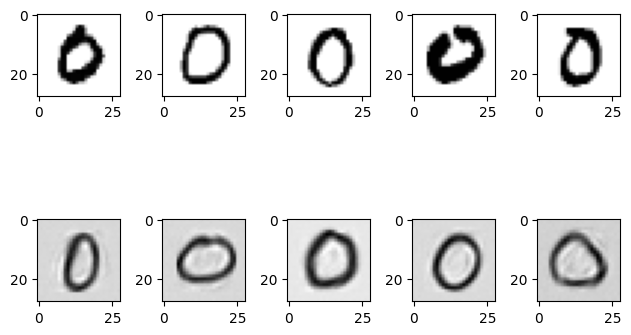

In [ ]:
for i in range(10):
    plt.subplot(2,5, i+1)
    if i < 5:
        plt.imshow(normal_test_input[i,...], cmap=plt.cm.gray_r)
    else:
        plt.imshow(recon_normal[i,...].detach().numpy(), cmap=plt.cm.gray_r)
plt.tight_layout()

### 비정상 테스트 데이터

비정상 테스트 데이터의 샘플결과입니다.

마찬가지로 상단이 실제 입력 데이터, 하단이 복원값이며,  
0을 제외한 데이터로 학습이 되지않았기때문에 복원이 이상하게 되는 것을 확인할 수 있습니다.

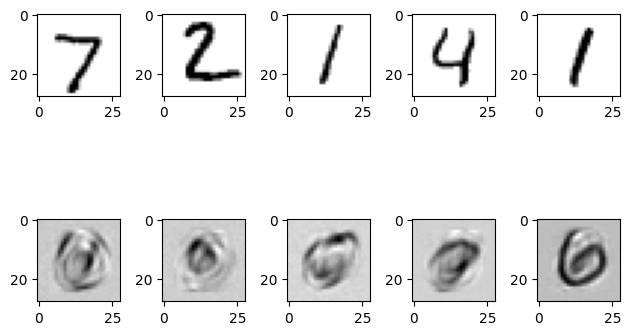

In [ ]:
for i in range(10):
    plt.subplot(2,5, i+1)
    if i < 5:
        plt.imshow(abnormal_test_input[i,...], cmap=plt.cm.gray_r)
    else:
        plt.imshow(recon_abnormal[i,...].detach().numpy(), cmap=plt.cm.gray_r)
plt.tight_layout()

## 성능 평가

모델로부터 확보한 이상점수를 기반으로 성능평가지표를 계산해보도록하겠습니다.

### ROC curve 와 AUROC

먼저 ROC curve를 그리고 AUROC를 계산해보도록 하겠습니다.

먼저 all_score는 정상, 비정상 테스트셋에 대한 이상점수입니다.
이상점수로는 복원오차인 mean squared error를 사용하였습니다.

all_label은 hold-out setting에 따른 정상/비정상 레이블입니다.
정상 데이터는 0으로, 비정상 데이터는 1로 레이블링합니다.

In [ ]:
all_score = np.concatenate([score_normal.detach().numpy(),score_abnormal.detach().numpy()])
all_label = np.concatenate([np.zeros(980),np.ones(980)]) # 정상 테스트 데이터 980개, 비정상 테스트 데이터 980개에 대한 정상/비정상 레이블

In [ ]:
all_label

array([0., 0., 0., ..., 1., 1., 1.])

Scikit-learn 내장 합수를 통해 fpr, tpr, auroc를 계산합니다.

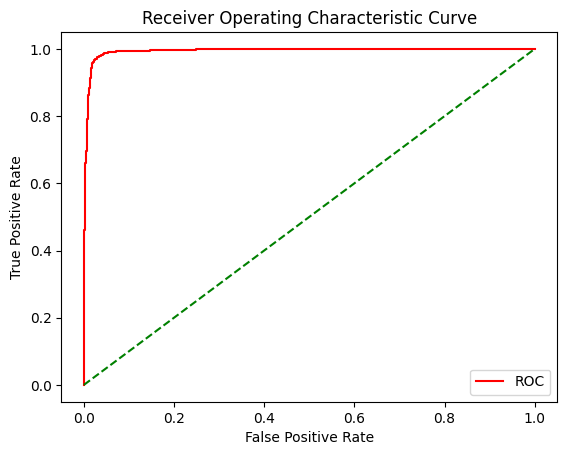

AUC : 0.9943096626405665


In [ ]:
from sklearn import metrics

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    auc = metrics.auc(fpr, tpr)
    print('AUC : {}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(all_label, all_score)
plot_roc_curve(fpr,tpr)


### Precision-recall curve와 PRAUC

다음으로 Imbalance 데이터 성능지표로 활용되는 Precision-recall curve와 PRAUC를 계산해보도록하겠습니다.


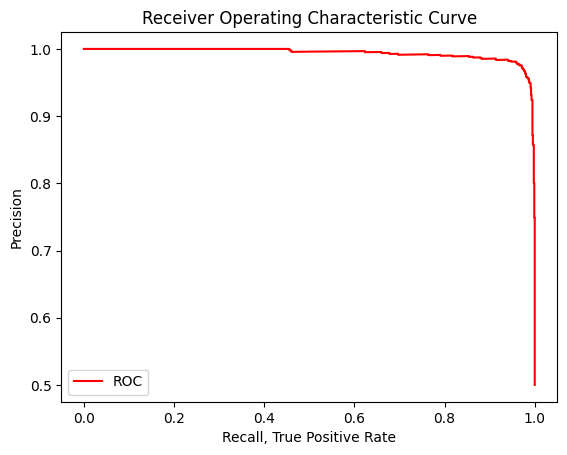

AUC : 0.9936853232258187


In [ ]:
def plot_pr_curve(precision, recall):
    plt.plot(recall, precision, color='red', label='ROC')
    # plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('Recall, True Positive Rate')
    plt.ylabel('Precision')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    auc = metrics.auc(recall, precision)
    print('AUC : {}'.format(auc))

precision, recall, thresh = metrics.precision_recall_curve(all_label, all_score)
plot_pr_curve(precision, recall)


### 이상점수 분포 확인

마지막으로 정상/비정상 데이터의 이상점수가 각각 어떻게 분포되어있는지 살펴보도록 하겠습니다.

<Axes: xlabel='SCORE', ylabel='Count'>

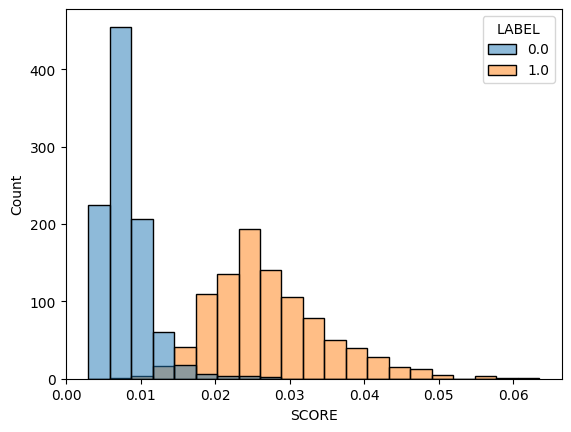

In [ ]:
import seaborn as sns

DF = pd.DataFrame({'SCORE':all_score, 'LABEL':all_label})
sns.histplot(DF,x='SCORE',hue='LABEL')

파란색은 정상 테스트 데이터의 이상점수 분포이고, 주황색은 비정상 테스트 데이터의 이상점수 분포입니다.
두 개의 점수 분포 사이의 분리가 어느정도 잘 이루어 지는 것을 확인 할 수 있습니다.

다시 위의 그래프를 학습된 정상 데이터에 대한 이상점수 분포를 포함하여 그려보도록하겠습니다. 학습 정상 데이터의 레이블은 -1로 설정하였습니다.

In [ ]:
recon_train_normal, score_train_normal = AE(normal_train_input[:980,...])
all_score_p = np.concatenate([score_train_normal.detach().numpy(), all_score])
all_label_p = np.concatenate([-1*np.ones(980), all_label])

<Axes: xlabel='SCORE', ylabel='Count'>

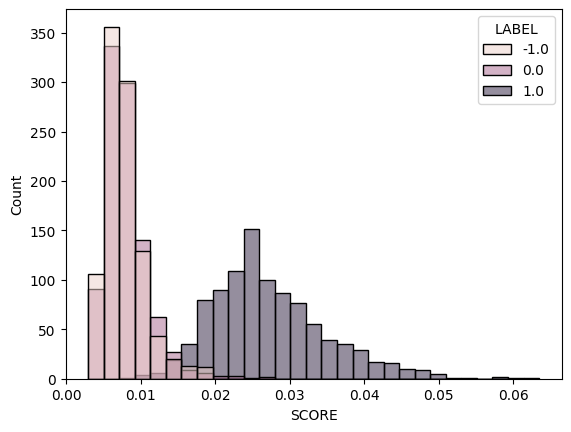

In [ ]:
DF2 = pd.DataFrame({'SCORE':all_score_p, 'LABEL':all_label_p})
sns.histplot(DF2,x='SCORE',hue='LABEL')

그래프를 보면 정상 학습데이터와 정상 테스트 데이터의 이상점수 분포는 유사하고, 비정상 테스트 데이터의 이상점수 분포는 나머지와 상이한, 이상탐지에서 원하는 형태의 결과가 나타나는 것을 볼 수 있습니다.

# Mahalanobis distance 활용

이번에는 예측 오차를 일종의 feature로 보고 Mahalanobis distance를 적용해보도록하겠습니다.
즉 오토인코더를 f(x) 라 하면 Mhalanobis distance를 계산하기 위해 사용되는 새로운 피쳐 벡터는 y = f(x)-x가 되게 됩니다.

결국 정상(학습)데이터의 오차 분포를 모델링하여 새로운 샘플의 오차와 학습 데이터의 분포 사이의 거리를 이상점수로 사용하게 됩니다.

In [ ]:
recon_train, score_train = AE(normal_train_input)
print("recon_shape", recon_train.shape)
print("input_shape", normal_train_input.shape)
## Mahalanobis distance를 계산하기 위해서 벡터형태로 바꿔줍니다.

train_err_np = (recon_train-normal_train_input).detach().numpy().reshape(-1,28*28)
train_err_np.shape

recon_shape torch.Size([5923, 28, 28])
input_shape torch.Size([5923, 28, 28])


In [ ]:
#동일한 작업을 정상 테스트, 비정상 테스트 데이터 셋에도 수행해줍니다.
#recon_normal, score_normal = AE(normal_test_input)
#recon_abnormal, score_abnormal = AE(abnormal_test_input)
test_normal_err_np = (recon_normal - normal_test_input).detach().numpy().reshape(-1,28*28)
test_abnormal_err_np = (recon_abnormal - abnormal_test_input).detach().numpy().reshape(-1,28*28)

Mahalanobis distance를 계산하기 위해서는 먼저 정상 데이터 분포에 대한 평균과 Covariance matrix를 구해야합니다. 이를 PCA를 통해서 수행해보겠습니다.


In [ ]:
from sklearn.decomposition import PCA
MaDis = PCA(whiten=True) #whiten option을 켜줘야 함)
MaDis.fit(train_err_np)

PCA(whiten=True)

이제 각 데이터에 대한 Mahalanobis distance를 구해보겠습니다.

In [ ]:
md_train = (MaDis.transform(train_err_np)**2).mean(-1)
md_test_normal = (MaDis.transform(test_normal_err_np)**2).mean(-1)
md_test_abnormal = (MaDis.transform(test_abnormal_err_np)**2).mean(-1)
print(md_train.shape, md_test_normal.shape, md_test_abnormal.shape)

(5923,) (980,) (980,)


이제 이전 모델과 마찬가지로 AUROC, PRAUC 분포 등을 확인해보겠습니다.

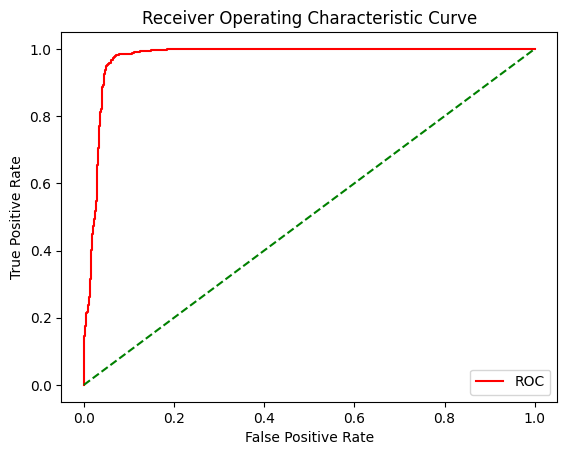

AUC : 0.9752634319033735


In [ ]:
all_md_score = np.concatenate([md_test_normal,md_test_abnormal])
md_fpr, md_tpr, md_thresh = metrics.roc_curve(all_label, all_md_score)
plot_roc_curve(md_fpr,md_tpr)

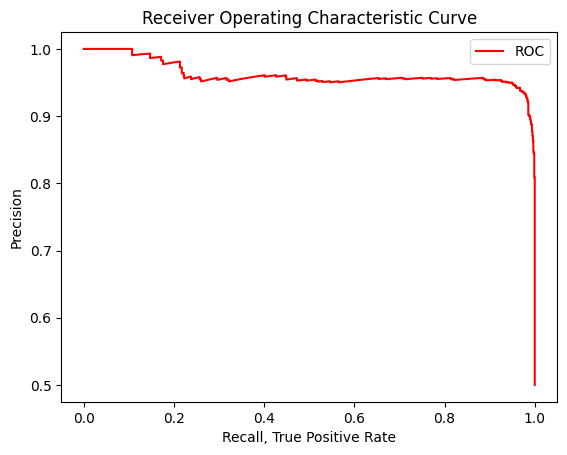

AUC : 0.9616181605073342


In [ ]:
md_precision, md_recall, md_thresh = metrics.precision_recall_curve(all_label, all_md_score)
plot_pr_curve(md_precision, md_recall)


In [ ]:
all_md_score_p = np.concatenate([md_train[:980], all_md_score])
all_md_label_p = np.concatenate([-1*np.ones(980), all_label])
DF2 = pd.DataFrame({'SCORE':all_md_score_p, 'LABEL':all_md_label_p})

In [ ]:
sns.histplot(DF2,x='SCORE',hue='LABEL')

2940

## 맺음말

지금까지 오토인코더와 MNIST 데이터셋을 이용한 전체 이상탐지 과정을 포함한 간단한 예제를 살펴보았습니다. 

다음 실습자료는 테이블 형식의 IRIS 데이터를 바탕으로 머신러닝 및 딥러닝 기반 이상탐지 라이브러리인 PyOD를 사용한 이상탐지 예제를 살펴보도록하겠습니다.

        문제 1. 원하는 모델을 만들어보세요
        self.autoencoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 28*28))

        문제 2. 
        output = self.autoencoder(x)
        mse = ((x.view(-1,28*28)-output)**2).mean(axis=1)
